Performing cross-validation evaluation...

Fold 1 Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



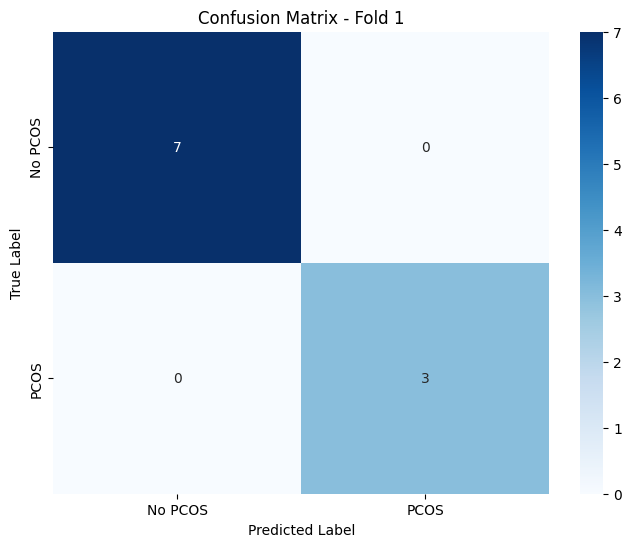


Fold 2 Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



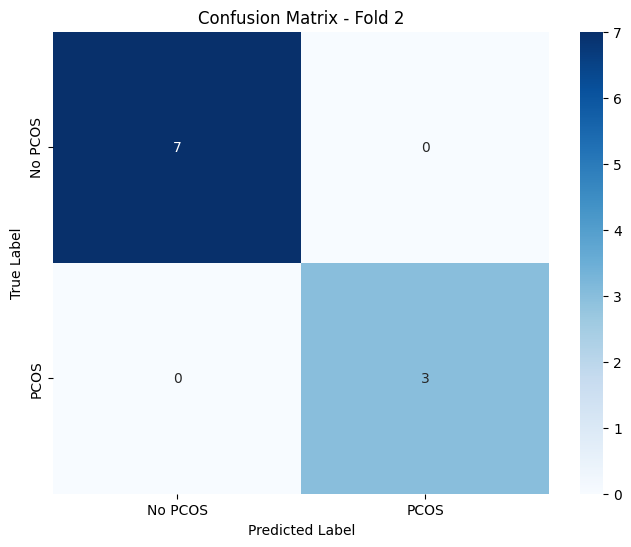


Fold 3 Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



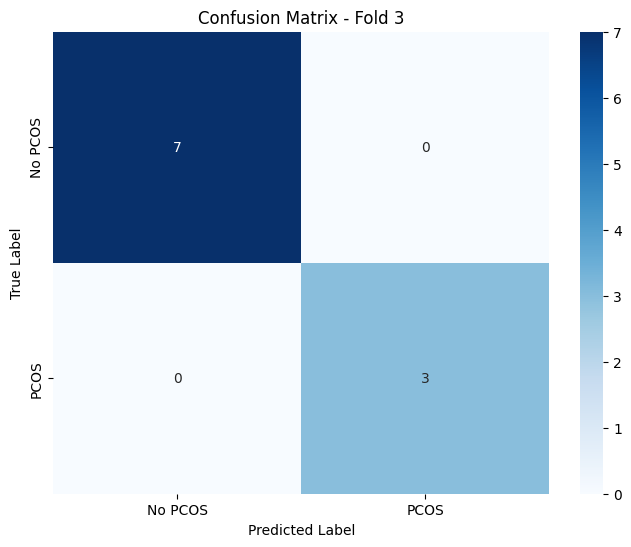


Fold 4 Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



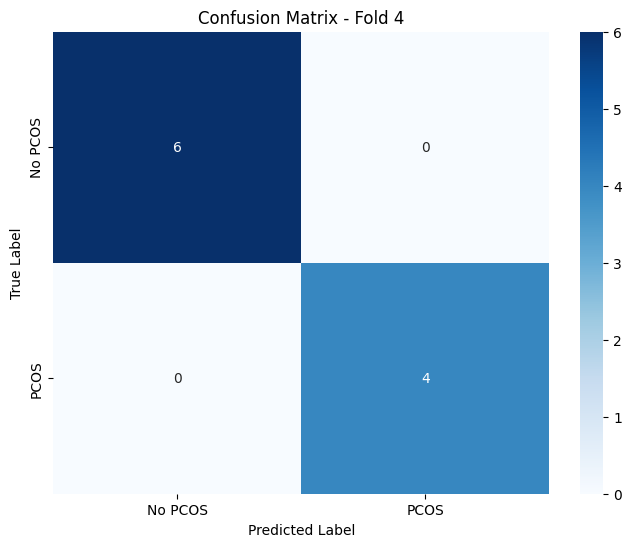


Fold 5 Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



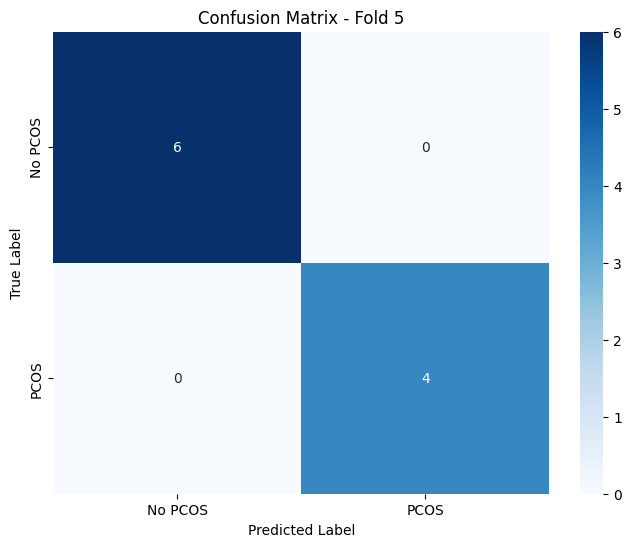


Cross-validation Results:
Mean Accuracy: 1.0000 (+/- 0.0000)
Individual fold scores: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']

Full Dataset Results:

Full Dataset Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        17

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



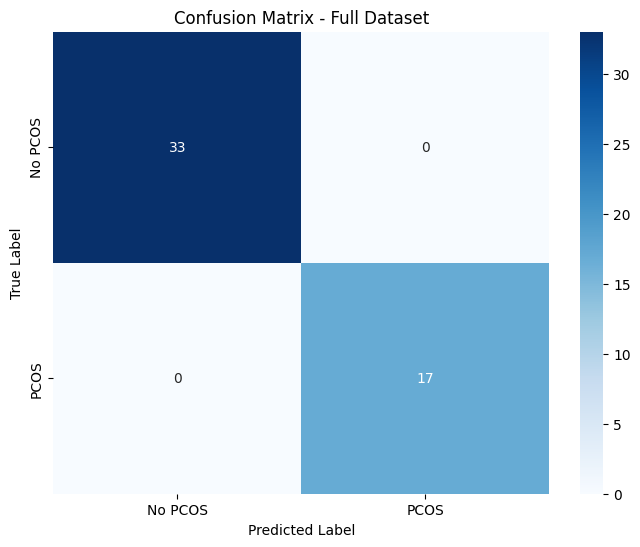


Full Dataset Additional Metrics:
Sensitivity (True Positive Rate): 1.0000
Specificity (True Negative Rate): 1.0000
Positive Predictive Value: 1.0000
Negative Predictive Value: 1.0000


In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import joblib
import seaborn as sns
import matplotlib.pyplot as plt


class BMFK:
    def __init__(self, n_neighbors=5, m=2, p=2, q=2):
        self.n_neighbors = n_neighbors
        self.m = m
        self.p = p
        self.q = q

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        # Using Euclidean distance (p=2)
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='minkowski', p=2)
        self.nn.fit(X)

    def bonferroni_mean(self, values):
        n = len(values)
        if n <= 1:
            return np.mean(values)
        sum_pq = 0
        for i in range(n):
            for j in range(n):
                if i != j:
                    sum_pq += values[i] ** self.p * values[j] ** self.q
        return (sum_pq / (n * (n - 1))) ** (1 / (self.p + self.q))

    def predict(self, X):
        predictions = []
        for x in X:
            distances, indices = self.nn.kneighbors([x])
            neighbor_labels = self.y[indices[0]]

            # Avoid division by zero or negative distances
            distances = distances[0]
            distances[distances == 0] = 1e-8

            # Calculate memberships
            memberships = 1 / (distances ** (2 / (self.m - 1)) + 1e-8)
            memberships /= np.sum(memberships)

            # Calculate class memberships using Bonferroni mean
            class_memberships = {}
            for c in self.classes:
                idx = neighbor_labels == c
                if np.any(idx):
                    class_memberships[c] = self.bonferroni_mean(memberships[idx])
                else:
                    class_memberships[c] = 0

            # Predict class with highest membership
            predictions.append(max(class_memberships, key=class_memberships.get))

        return np.array(predictions)

def load_and_preprocess_data(file_path):
    # Load data
    df = pd.read_excel(file_path)
    
    # Drop unnecessary columns
    df = df.drop(columns=['Sl. No', 'Patient File No.', 'Unnamed: 44'], errors='ignore')
    
    # Convert to numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Fill missing values
    df.fillna(df.median(), inplace=True)
    
    # Encode categorical variables
    categorical_columns = [
        'Blood Group', 'Cycle(R/I)', 'Pregnant(Y/N)',
        'Weight gain(Y/N)', 'hair growth(Y/N)',
        'Skin darkening (Y/N)', 'Hair loss(Y/N)',
        'Pimples(Y/N)', 'Fast food (Y/N)',
        'Reg.Exercise(Y/N)'
    ]
    
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category').cat.codes
    
    return df

def evaluate_model(model, X, y):
    """Evaluate model using cross-validation"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_val = X[val_idx]
        y_val = y[val_idx]
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # Calculate accuracy
        acc = accuracy_score(y_val, y_pred)
        cv_scores.append(acc)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))
        
        # Plot confusion matrix for each fold
        conf_matrix = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No PCOS', 'PCOS'],
                    yticklabels=['No PCOS', 'PCOS'])
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    return cv_scores

def test_model():
    # Load the data
    file_path = "PCOS_test_data_modified.xlsx"  # Update this path
    df = load_and_preprocess_data(file_path)
    
    # Separate features and target
    X = df.drop(columns=['PCOS (Y/N)'], errors='ignore')
    y = df['PCOS (Y/N)'].values
    
    # Load the saved model and scaler
    saved_data = joblib.load('proposed_bmfk_model.pkl')
    model = saved_data['model']
    scaler = saved_data['scaler']
    
    # Scale the features
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    
    # Get the selected features used in training
    selected_features = [
        'Follicle No. (L)', 'hair growth(Y/N)', 'Follicle No. (R)',
        'Cycle(R/I)', 'Fast food (Y/N)', 'Skin darkening (Y/N)',
        'Cycle length(days)', 'LH(mIU/mL)', 'FSH(mIU/mL)', ' Age (yrs)', 
        'Weight (Kg)', 'Marraige Status (Yrs)', 'PRL(ng/mL)'
    ]
    
    # Select only the features used in training
    X_selected = X_scaled[selected_features]
    
    print("Performing cross-validation evaluation...")
    cv_scores = evaluate_model(model, X_selected.values, y)
    
    print("\nCross-validation Results:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
    
    # Make predictions on the entire dataset
    print("\nFull Dataset Results:")
    y_pred_full = model.predict(X_selected.values)
    print("\nFull Dataset Classification Report:")
    print(classification_report(y, y_pred_full))
    
    # Plot final confusion matrix for full dataset
    conf_matrix_full = confusion_matrix(y, y_pred_full)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_full, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No PCOS', 'PCOS'],
                yticklabels=['No PCOS', 'PCOS'])
    plt.title('Confusion Matrix - Full Dataset')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate and print additional metrics for full dataset
    tn, fp, fn, tp = conf_matrix_full.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    print("\nFull Dataset Additional Metrics:")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Positive Predictive Value: {ppv:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")

if __name__ == "__main__":
    test_model()